## Data Exploration

### Importing Libraries

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from colorama import Fore, Style
from tabulate import tabulate

### Loading Dataset

In [114]:
data = pd.read_csv('fraudTrain.csv')
print(data.info())
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

#### Here, we have loaded dataset and showed basic information about our dataset.

### Data Preprocessing and cleaning 

In [117]:
data = data.drop(columns=['Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'trans_num'])

data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['transaction_hour'] = data['trans_date_trans_time'].dt.hour
data['transaction_day'] = data['trans_date_trans_time'].dt.day
data['transaction_dayofweek'] = data['trans_date_trans_time'].dt.dayofweek

data['dob'] = pd.to_datetime(data['dob'])
data['age'] = (data['trans_date_trans_time'] - data['dob']).dt.days // 365
data = data.drop(columns=['trans_date_trans_time', 'dob'])

data['gender_encoded'] = data['gender'].map({'M': 1, 'F': 0})
data = pd.get_dummies(data, columns=['category'], drop_first=True)
data = data.drop(columns=['gender']) 

#### In this we have first droped irrelevant columns then converted transaction date to datetime and extract features. we have also calculated age and droped dob.

### Feature Engineering

In [122]:
data['distance'] = data.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).miles, axis=1)
data['amt_per_capita'] = data['amt'] / (data['city_pop'] + 1)

#### We have calculated distance between user and merchant and calculated population of the city.

In [124]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"Encoding column: {col}")
        label_encoder = LabelEncoder()
        data[col] = label_encoder.fit_transform(data[col])

print("Columns after encoding non-numeric values:", data.columns)
data = data.drop(columns=['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'street', 'city', 'state', 'zip', 'lat', 'long', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long'], errors='ignore')

X = data.drop(columns=['is_fraud'])
y = data['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Encoding column: merchant
Encoding column: job
Columns after encoding non-numeric values: Index(['merchant', 'amt', 'lat', 'long', 'city_pop', 'job', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'transaction_hour',
       'transaction_day', 'transaction_dayofweek', 'age', 'gender_encoded',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'distance', 'amt_per_capita'],
      dtype='object')


### Exploratory Data Analysis

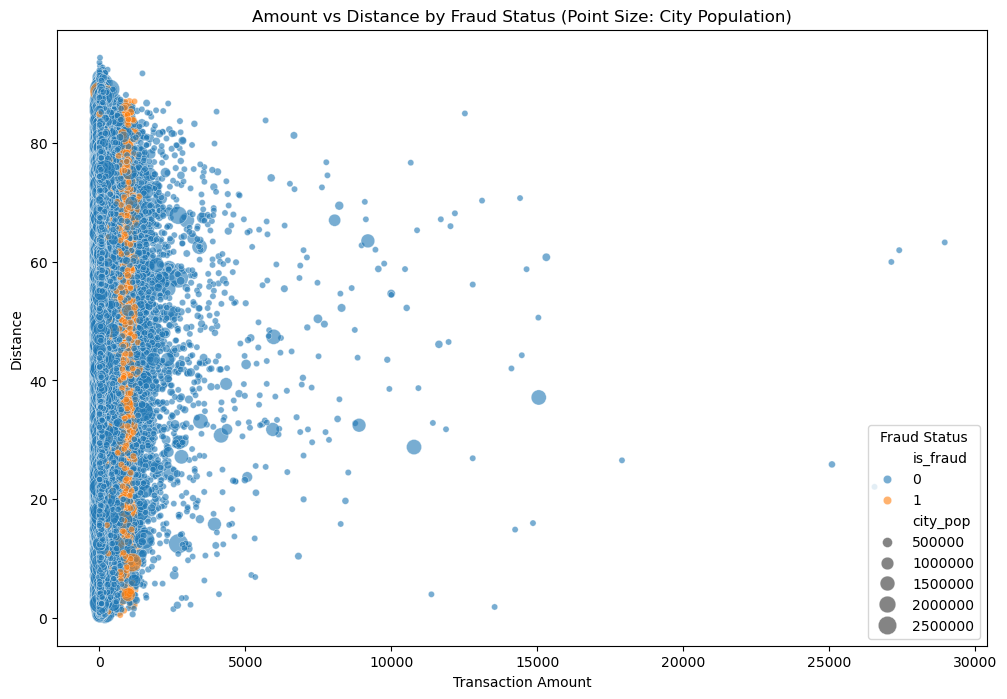

In [126]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=data,
    x='amt',
    y='distance',
    hue='is_fraud',
    size='city_pop',
    alpha=0.6,
    sizes=(20, 200) 
)
plt.title('Amount vs Distance by Fraud Status (Point Size: City Population)')
plt.xlabel('Transaction Amount')
plt.ylabel('Distance')
plt.legend(title='Fraud Status')
plt.show()

#### from the above figure we can see fraud happens more with big amounts and unusual distances and Non-fraudulent transactions cluster around small amounts and shorter distances.This plot Highlights fraud status and city population trends.

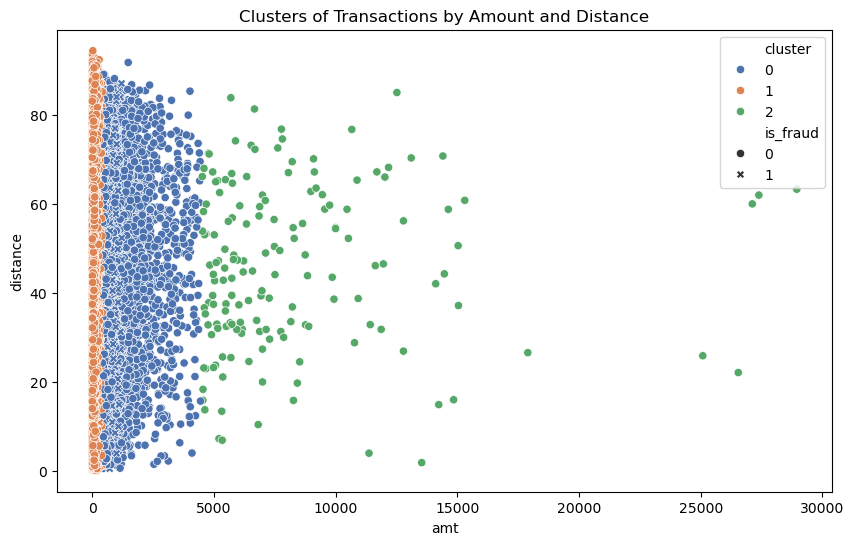

In [128]:
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['amt', 'distance', 'transaction_hour']])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='amt', y='distance', hue='cluster', style='is_fraud', palette='deep')
plt.title('Clusters of Transactions by Amount and Distance')
plt.show()

#### This plot uses KMeans clustering to group transactions into 3 clusters based on transaction amount,transaction distance and time of transaction.This is used to identify clusters and analyze fraud within them.

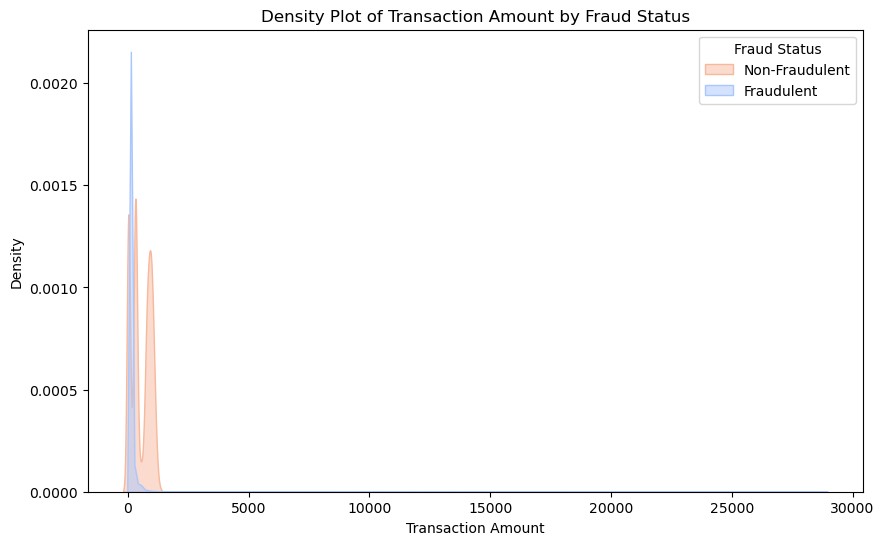

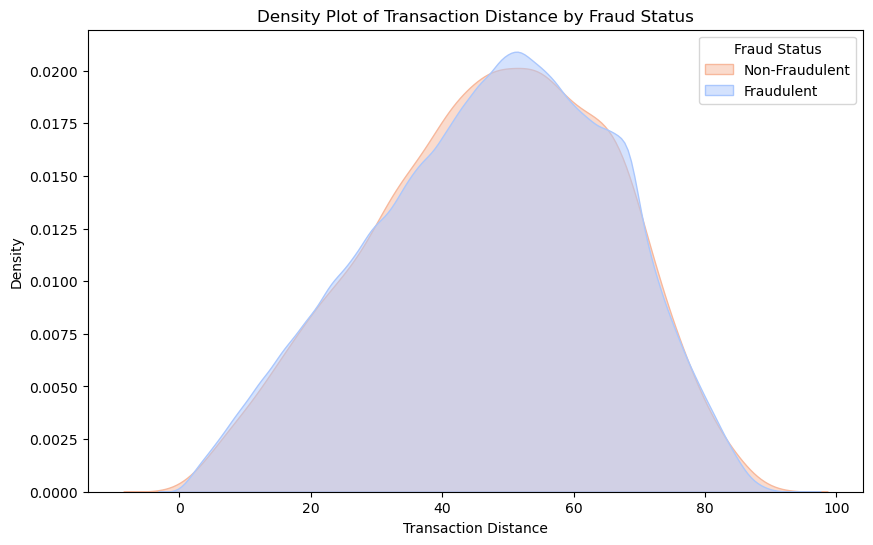

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# Density plot for Transaction Amount (amt)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='amt', hue='is_fraud', fill=True, common_norm=False, palette='coolwarm', alpha=0.5)
plt.title('Density Plot of Transaction Amount by Fraud Status')
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.legend(title='Fraud Status', labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()

# Density plot for Transaction Distance (distance)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='distance', hue='is_fraud', fill=True, common_norm=False, palette='coolwarm', alpha=0.5)
plt.title('Density Plot of Transaction Distance by Fraud Status')
plt.xlabel('Transaction Distance')
plt.ylabel('Density')
plt.legend(title='Fraud Status', labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()

#### In the above first graph when there is a peak, it can be faund fraud transaction and when there is a low peak it can be non-fraud transaction. In the second graph when there is peak at longer distances, indicates unusual locations for fraudulent activity and when the peak is at shorter distances, represents normal behavior close to the user's location.

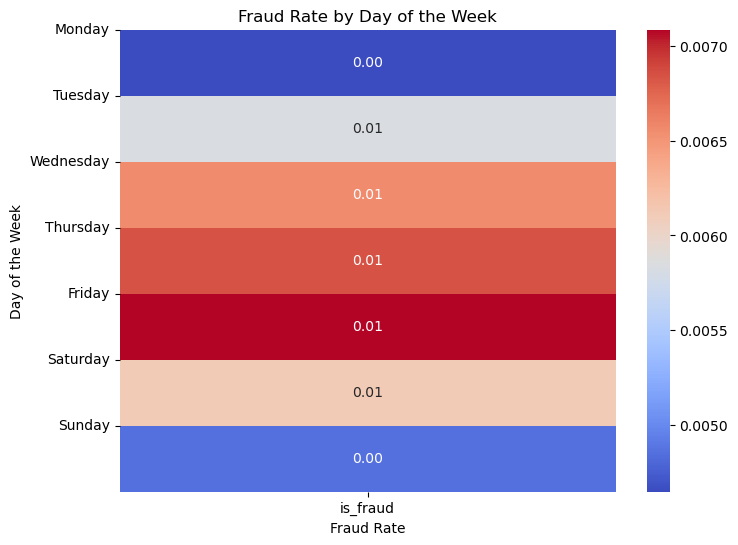

In [130]:
fraud_rate_week = data.pivot_table(
    index='transaction_dayofweek', 
    values='is_fraud', 
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(fraud_rate_week, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Fraud Rate by Day of the Week')
plt.xlabel('Fraud Rate')
plt.ylabel('Day of the Week')
plt.yticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.show()

#### In the above heat map we can observe fraud rate by days. We can see that the most fraud chances have occured in the weekends.

### Basic model training

In [133]:
random_forest_model = RandomForestClassifier(random_state=42)
gradient_boosting_model = GradientBoostingClassifier(random_state=42)
neural_network_model = MLPClassifier(random_state=42, max_iter=1000)
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
lightgbm_model = LGBMClassifier(random_state=42, verbose=-1) 
easy_ensemble_model = EasyEnsembleClassifier(random_state=42, n_estimators=10)

models = {
    "Random Forest": random_forest_model,
    "Gradient Boosting": gradient_boosting_model,
    "Neural Network": neural_network_model,
    "XGBoost": xgboost_model,
    "LightGBM": lightgbm_model,
    "Easy Ensemble": easy_ensemble_model  
}

results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }

    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


Training Random Forest...

Random Forest Evaluation Metrics:
Accuracy: 0.9985
Precision: 0.9734
Recall: 0.7711
F1-Score: 0.8605
ROC-AUC Score: 0.9907

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.97      0.77      0.86      1520

    accuracy                           1.00    259335
   macro avg       0.99      0.89      0.93    259335
weighted avg       1.00      1.00      1.00    259335


Training Gradient Boosting...

Gradient Boosting Evaluation Metrics:
Accuracy: 0.9969
Precision: 0.8119
Recall: 0.6105
F1-Score: 0.6970
ROC-AUC Score: 0.9729

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.81      0.61      0.70      1520

    accuracy                           1.00    259335
   macro avg       0.90      0.80      0.85    259335
weighted avg       1.00      1.00      1.

#### Here, we have trained various models which have different accuracy, precision, recall, F1-score, and ROC-AUC Score.

### Hyperparameter Tunning

In [32]:
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "Neural Network": {
        "hidden_layer_sizes": [(50,), (100,)],
        "activation": ["relu"],
        "solver": ["adam"],
        "alpha": [0.001, 0.01],
        "learning_rate": ["constant"]
    },
    "XGBoost": {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "gamma": [0, 0.1, 0.2]
    },
    "LightGBM": {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1],
        "num_leaves": [15, 31, 63],
        "max_depth": [-1, 10, 20],
        "min_child_samples": [10, 20],
        "subsample": [0.6, 0.8, 1.0]
    },
    "Easy Ensemble": {
        "n_estimators": [10, 20]  .,nb   
    }
}

tuned_models = {}

for model_name, model in models.items():
    if model_name in param_grids:
        print(f"Starting tuning for {model_name}...")
        grid_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[model_name],
            n_iter=10,  
            scoring="f1", 
            cv=3,  
            random_state=42,
            n_jobs=-1 
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        tuned_models[model_name] = best_model
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best model for {model_name}: {best_model}\n")
    else:
        print(f"Skipping tuning for {model_name} as no parameter grid is defined.\n")


Starting tuning for Random Forest...
Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best model for Random Forest: RandomForestClassifier(random_state=42)

Starting tuning for Gradient Boosting...
Best parameters for Gradient Boosting: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}
Best model for Gradient Boosting: GradientBoostingClassifier(max_depth=5, min_samples_leaf=2, random_state=42)

Starting tuning for Neural Network...
Best parameters for Neural Network: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50,), 'alpha': 0.001, 'activation': 'relu'}
Best model for Neural Network: MLPClassifier(alpha=0.001, hidden_layer_sizes=(50,), max_iter=1000,
              random_state=42)

Starting tuning for XGBoost...
Best parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1

#### In this we have done Hyperparameter grids for each model and tuned each model.

In [34]:
tuned_results = {}
best_score = -1  
best_model_name = ""
best_model = None

for model_name, model in tuned_models.items():
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    tuned_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }
    
    if f1 > best_score:  
        best_model = model
        best_model_name = model_name
        best_score = f1

print("\nOverall Tuned Model Performance Comparison:")
for model_name, metrics in tuned_results.items():
    print(f"\n{model_name}:")
    for metric, score in metrics.items():
        if score is not None:
            print(f"{metric}: {score:.4f}")

print(f"\nThe best model is {best_model_name} with an F1-Score of {best_score:.4f}")


Overall Tuned Model Performance Comparison:

Random Forest:
Accuracy: 0.9985
Precision: 0.9734
Recall: 0.7711
F1-Score: 0.8605
ROC-AUC: 0.9907

Gradient Boosting:
Accuracy: 0.9985
Precision: 0.9367
Recall: 0.7987
F1-Score: 0.8622
ROC-AUC: 0.9929

Neural Network:
Accuracy: 0.9984
Precision: 0.9554
Recall: 0.7612
F1-Score: 0.8473
ROC-AUC: 0.9958

XGBoost:
Accuracy: 0.9989
Precision: 0.9615
Recall: 0.8375
F1-Score: 0.8952
ROC-AUC: 0.9988

LightGBM:
Accuracy: 0.9984
Precision: 0.9910
Recall: 0.7257
F1-Score: 0.8378
ROC-AUC: 0.9927

Easy Ensemble:
Accuracy: 0.9447
Precision: 0.0901
Recall: 0.9270
F1-Score: 0.1642
ROC-AUC: 0.9834

The best model is XGBoost with an F1-Score of 0.8952


#### We have evaluated the tuned models on the test set and calculated performance metrics. We determined whether the model is best, based on the F1-Score or ROC-AUC and showed overall performance comparison and found best model according to F1-Score.

### Prediction using Best model

In [148]:
predictions = best_model.predict(X_test)
fraud_probabilities = best_model.predict_proba(X_test)[:, 1]

detailed_results = pd.DataFrame(X_test, columns=X.columns).copy() 
detailed_results['Prediction'] = predictions
detailed_results['Fraud_Probability'] = fraud_probabilities

detailed_results['Fraud_Status'] = detailed_results['Prediction'].map({1: "Fraud", 0: "Not Fraud"})

mean = 12  
std_dev = 4  
detailed_results['transaction_hour_raw'] = (detailed_results['transaction_hour'] * std_dev) + mean
detailed_results['transaction_hour_raw'] = detailed_results['transaction_hour_raw'].round().astype(int) 

detailed_results['transaction_hour_category'] = detailed_results['transaction_hour_raw'].apply(
    lambda hour: "Night" if (hour >= 19 or hour < 7) else "Day"
)

detailed_results['transaction_hour'] = detailed_results.apply(
    lambda row: f"{row['transaction_hour_category']} ({row['transaction_hour_raw']}:00)", axis=1
)

amt_mean = 500  
amt_std_dev = 200 
detailed_results['amt'] = (detailed_results['amt'] * amt_std_dev) + amt_mean


columns_to_check = ['amt', 'transaction_day', 'amt_per_capita'] 
if all(col in detailed_results.columns for col in columns_to_check):
    detailed_results = detailed_results[(detailed_results[columns_to_check] >= 0).all(axis=1)]

output_columns = ['amt', 'transaction_hour', 'transaction_day', 
                  'amt_per_capita', 'Fraud_Status', 'Fraud_Probability']

if all(col in detailed_results.columns for col in output_columns):
    detailed_output = detailed_results[output_columns]
else:
    raise ValueError("One or more columns specified in `output_columns` are missing from the dataset.")

detailed_output['amt_per_capita'] = detailed_output['amt_per_capita'].apply(
    lambda x: f"${x:.2f} per person" if x < 1 else f"${x:.2f}"
)

detailed_output['amt'] = detailed_output['amt'].apply(lambda x: f"${x:,.2f}") 
detailed_output['transaction_day'] = detailed_output['transaction_day'].apply(
    lambda x: ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"][int(x) % 7]
) 

pd.set_option('display.float_format', '{:,.2f}'.format)

detailed_output = detailed_output.sort_values(by='Fraud_Probability', ascending=False)

fraudulent_transactions = detailed_output[detailed_output['Fraud_Status'] == "Fraud"].head(10)
non_fraudulent_transactions = detailed_output[detailed_output['Fraud_Status'] == "Not Fraud"].head(10)

print(Fore.RED + "\nTop 10 Predicted Fraudulent Transactions:" + Style.RESET_ALL)
print(tabulate(fraudulent_transactions, headers="keys", tablefmt="grid", showindex=False))

print(Fore.GREEN + "\nTop 10 Predicted Non-Fraudulent Transactions:" + Style.RESET_ALL)
print(tabulate(non_fraudulent_transactions, headers="keys", tablefmt="grid", showindex=False))

fraudulent_transactions.to_csv("top_fraudulent_transactions.csv", index=False)
non_fraudulent_transactions.to_csv("top_non_fraudulent_transactions.csv", index=False)



Top 10 Predicted Fraudulent Transactions:
+-----------+--------------------+-------------------+------------------+----------------+---------------------+
| amt       | transaction_hour   | transaction_day   | amt_per_capita   | Fraud_Status   |   Fraud_Probability |
+===========+====================+===================+==================+================+=====================+
| $792.71   | Night (6:00)       | Monday            | $0.14 per person | Fraud          |            0.999828 |
+-----------+--------------------+-------------------+------------------+----------------+---------------------+
| $1,664.15 | Day (18:00)        | Monday            | $0.05 per person | Fraud          |            0.999768 |
+-----------+--------------------+-------------------+------------------+----------------+---------------------+
| $421.05   | Night (6:00)       | Monday            | $0.08 per person | Fraud          |            0.999592 |
+-----------+--------------------+-------------------

#### Here, we have sorted fraud probability for a better view and displayed top fraudulent transactions and also displayed top non-fraudulent transactions.

### Conclusion

#### Fraudulent Behavior Trends:
#### The fraudsters tend to operate outside regular business hours, target high-value transactions, and exploit regions with fewer people or systems to monitor their activity.

#### Model Accuracy:
#### The fraud detection model demonstrates a good accuracy in separating fraud from non-fraud based on key features such as amount, transaction hour, and amount per capita.

#### Data Quality and Insights:
#### The derived features such as amount per capita, transaction hour, etc. plays an significant role in identifying fraud. Their inclusion enhances the model's ability to detect anomalies.
